In [1]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

from test_model import test_model
from train_model import train_model

%matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = "cpu"

In [3]:
data_dir = "tiny-224/"
num_workers = {"train": 4, "val": 0, "test": 0}
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
        ]
    ),
    "test": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
        ]
    ),
}
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "val", "test"]
}
dataloaders = {
    x: data.DataLoader(image_datasets[x], batch_size=100, shuffle=True, num_workers=num_workers[x])
    for x in ["train", "val", "test"]
}

In [4]:
# Load Resnet18
torch.manual_seed(42)
model_ft = models.resnet18(weights="IMAGENET1K_V1")
# Finetune Final few layers to adjust for tiny imagenet input
model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
num_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_features, 200)
model_ft = model_ft.to(device)

# Loss Function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

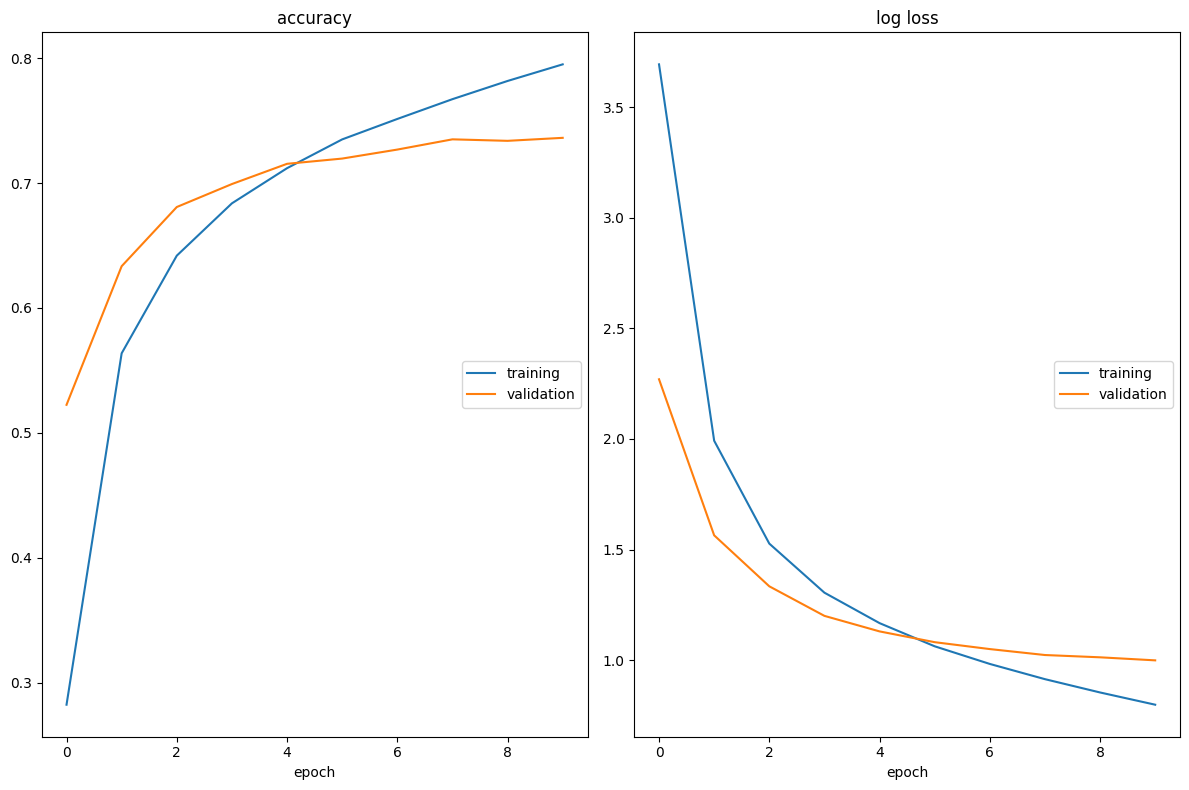

accuracy
	training         	 (min:    0.282, max:    0.795, cur:    0.795)
	validation       	 (min:    0.522, max:    0.736, cur:    0.736)
log loss
	training         	 (min:    0.798, max:    3.693, cur:    0.798)
	validation       	 (min:    0.999, max:    2.269, cur:    0.999)
Training complete in 46m 44s
Best Validation Accuracy: 0.7361999750137329, Epoch: 10


In [5]:
# Train
best_epoch = train_model(
    output_path="RestNet18_224",
    model=model_ft,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer_ft,
    device=device,
    num_epochs=10,
)

In [6]:
# Test
model_ft.load_state_dict(torch.load(f"models/RestNet18_224/model_{best_epoch}_epoch.pt"))
test_model(model=model_ft, dataloaders=dataloaders, criterion=criterion, device=device)

Test Loss: 0.9919 Acc: 0.7426
Test complete in 0m 8s
